In [9]:
import os
import torch
from torch import nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

%run Model.ipynb
%run DataLoader.ipynb

cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
images_dir = "/home/mj/HardDisk/Github/Image_Compressor/Dataset/Open_images_2019/train"
outputs_dir = "/home/mj/HardDisk/Github/Image_Compressor/Model"
batch_size = 8
threads = 4
lr = 5e-4
num_epochs = 100
patch_size = 128
jpeg_quality = 10
use_augmentation = True
use_fast_loader = False


model = My_Model()

model = model.to(device)
criterion = nn.MSELoss(reduction='sum')

optimizer = optim.Adam([
    {'params': model.base.parameters()},
    {'params': model.last.parameters(), 'lr': lr * 0.5},
], lr=lr)

dataset = Dataset(images_dir, patch_size, jpeg_quality, use_augmentation, use_fast_loader)
dataloader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=threads,
                        pin_memory=True,
                        drop_last=True)


for epoch in range(num_epochs):
    epoch_losses = AverageMeter()
    target_losses = AverageMeter()

    with tqdm(total=(len(dataset) - len(dataset) % batch_size)) as _tqdm:
        _tqdm.set_description('epoch: {}/{}'.format(epoch + 1, num_epochs))
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)

            loss = criterion(preds, labels)
            target = criterion(inputs, labels)

            epoch_losses.update(loss.item(), len(inputs))
            target_losses.update(target.item(), len(inputs))


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _tqdm.set_postfix(loss='{:.6f}, target{:.6f}'.format(epoch_losses.avg, target_losses.avg))
            _tqdm.update(len(inputs))

    torch.save(model.state_dict(), os.path.join(outputs_dir, 'My_Model_epoch_{}.pth'.format(epoch)))
    
    if((epoch+1)%20):
        optimizer = optim.Adam([
            {'params': model.base.parameters()},
            {'params': model.last.parameters(), 'lr': lr * 0.5},
        ], lr=lr*0.5)

epoch: 78/100: 100%|██████████| 99992/99992 [12:56<00:00, 128.82it/s, loss=634.243861, target912.516080]


epoch: 100/100: 100%|██████████| 99992/99992 [12:57<00:00, 128.67it/s, loss=634.075064, target914.733774]


In [13]:
import matplotlib.pyplot as plt
import torchvision

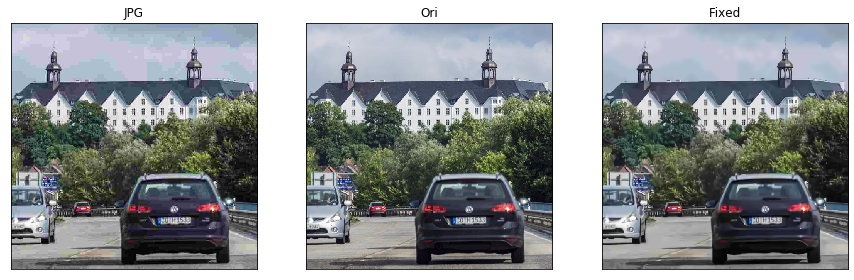

In [194]:
patch_size = 640

test_dir = "/home/mj/HardDisk/Github/Image_Compressor/Dataset/DIV2K_valid_HR"
test_dataset = Dataset(images_dir, patch_size, jpeg_quality, False, use_fast_loader)
test_dataloader = DataLoader(dataset=test_dataset,
                        batch_size=1,
                        shuffle=True,
                        num_workers=1,
                        pin_memory=True,
                        drop_last=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for data in test_dataloader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    preds = model(inputs)
    
#     print((inputs*255).type(torch.cuda.ByteTensor))
#     print((labels*255).type(torch.cuda.ByteTensor))
#     print((preds*255).type(torch.cuda.ByteTensor))

# torchvision.utils.make_grid(images, nrow=5).permute(1, 2, 0)

    inputs = (inputs*255).cpu().type(torch.ByteTensor)
    labels = (labels*255).cpu().type(torch.ByteTensor)
    preds = (preds*255).cpu().type(torch.ByteTensor)
    
    plt.figure(figsize=(15, 15));
    plt.subplot(131);plt.imshow(torchvision.utils.make_grid(inputs,nrow=1).permute(1, 2, 0));plt.title("JPG");plt.xticks([]);plt.yticks([]);
    plt.subplot(132);plt.imshow(torchvision.utils.make_grid(labels,nrow=1).permute(1, 2, 0));plt.title("Ori");plt.xticks([]);plt.yticks([]);
    plt.subplot(133);plt.imshow(torchvision.utils.make_grid(preds,nrow=1).permute(1, 2, 0));plt.title("Fixed");plt.xticks([]);plt.yticks([]);
    plt.show()
    
    break